# Contrastive Learning with SimCLR
---

In [1]:
import os
from copy import deepcopy
import random

import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import seaborn as sns
import numpy as np

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Use as many workers as possible in a data loader
NUM_WORKERS = os.cpu_count()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Random seed set as 42
Device: cuda:0
Number of workers: 2


<Figure size 640x480 with 0 Axes>

## Data Augmentation for Contrastive Learning

To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice.

In [2]:
class ContrastiveTransformations:
    """
    Take two random crops of one image, and apply a set of
    augmentations.
    """
    def __init__(self, base_transforms, n_views=2):
        self.base_transformt = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transformt(x) for i in range(self.n_views)]
        return views

The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data.

for our experiments, we apply a set of 5 transformations following the original SimCLR setup: random horizontal flip, crop-and-resize (size=96), color distortion (brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1), random grayscale, and gaussian blur (kerenel_size=9). In comparison to the original implementation, we reduce the effect of the color jitter slightly (0.5 instead of 0.8 for brightness, contrast, and saturation, and 0.1 instead of 0.2 for hue).

In [3]:
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=96),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Dataset

In this homework, we will use the STL10 dataset, which, similarly to CIFAR10, contains images of 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck. However, the images have a higher resolution, namely $96\times 96$
 pixels, and we are only provided with 500 labeled images per class. Additionally, we have a much larger set of 100,000
 unlabeled images which are similar to the training images but are sampled from a wider range of animals and vehicles. This makes the dataset ideal to showcase the benefits that self-supervised learning offers.

In [4]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True, transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True, transform=ContrastiveTransformations(contrast_transforms, n_views=2))

100%|██████████| 2.64G/2.64G [01:48<00:00, 24.3MB/s]


Extracting ../data/stl10_binary.tar.gz to ../data
Files already downloaded and verified


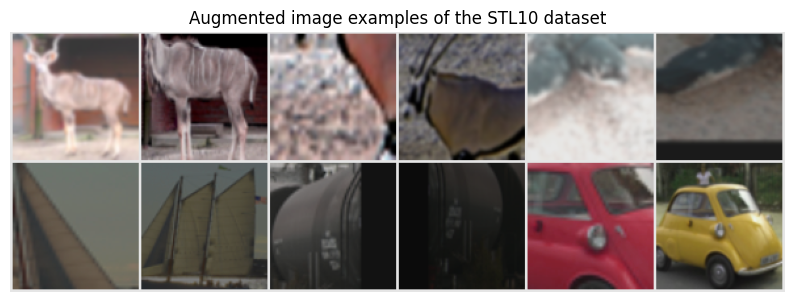

In [5]:
# Visualize some examples
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## SimCLR Implementation

In [6]:
class SimCLR(nn.Module):

    def __init__(self, hidden_dim, output_dim):
        super().__init__()

        # Base mdoel f(.)
        self.f = torchvision.models.resnet18(num_classes=hidden_dim, pretrained=False)

        # Projection head g(.)
        self.g = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=output_dim)
        )

    def forward(self, x):
        return self.g(self.f(x))

### InfoNCE loss

InfoNCE, where NCE stands for Noise-Contrastive Estimation, is a type of contrastive loss function used for self-supervised learning.


$l_{ij}=log(\frac{exp(sim(z_i, z_j)/\tau)}{\sum_{k=1}^{2N}𝟙_{k\neq i}exp(sim(z_i, z_k)/\tau)}) $

$sim(z_i, z_j) = \frac{z_i^T.z_j}{\|z_i\|.\|z_j\|}$

Using this loss we want to maximize the similarity between the representations of the two augmented versions of the same image, while minimizing it to all other examples in the batch.

**TODO: Implement this loss function in cell below: (50)**

In [7]:
def info_nce_loss(features_1, features_2, temperature=0.5):
    
    features = torch.cat([features_1, features_2], dim=0)  
    batch_size = features_1.shape[0]
    similarity_matrix = torch.mm(features, features.T)  
    norms = torch.norm(features, dim=1, keepdim=True)
    similarity_matrix = similarity_matrix / (norms @ norms.T + 1e-8)  
    similarity_matrix = similarity_matrix / temperature  

    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=features.device)
    similarity_matrix = similarity_matrix.masked_fill(mask, float('-inf'))

    positives = torch.cat([
        torch.arange(batch_size, 2 * batch_size, device=features.device),
        torch.arange(0, batch_size, device=features.device)
    ])
    positive_similarity = similarity_matrix[torch.arange(2 * batch_size, device=features.device), positives]
    denominator = torch.logsumexp(similarity_matrix, dim=1)
    loss = -torch.mean(positive_similarity - denominator)
    return loss

### Training SimCLR

**TODO: Implement the training and evaluation loops for the SimCLR model: (20)**

In [8]:
from tqdm.notebook import tqdm

train_loader = DataLoader(unlabeled_data, batch_size=1024, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(train_data_contrast, batch_size=1024, shuffle=False, num_workers=NUM_WORKERS)
simclr_model = SimCLR(hidden_dim=512, output_dim=128).to(device)
optimizer = optim.Adam(simclr_model.parameters(), lr=5e-4, weight_decay=1e-4)

# Training loop
n_epochs = 5
temperature = 0.07
for epoch in range(n_epochs):
    simclr_model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Training"):
        images_1, images_2 = batch[0]  
        images_1, images_2 = images_1.to(device), images_2.to(device)
        features_1 = simclr_model(images_1)  
        features_2 = simclr_model(images_2) 
        loss = info_nce_loss(features_1, features_2, temperature)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}")

    simclr_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation"):
            images_1, images_2 = batch[0]
            images_1, images_2 = images_1.to(device), images_2.to(device)
            features_1 = simclr_model(images_1)
            features_2 = simclr_model(images_2)
            loss = info_nce_loss(features_1, features_2, temperature)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{n_epochs}, Validation Loss: {val_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/5 - Training:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 1/5, Training Loss: 6.3054


Epoch 1/5 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5, Validation Loss: 5.4375


Epoch 2/5 - Training:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2/5, Training Loss: 4.6561


Epoch 2/5 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/5, Validation Loss: 4.1392


Epoch 3/5 - Training:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3/5, Training Loss: 3.6507


Epoch 3/5 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/5, Validation Loss: 3.4680


Epoch 4/5 - Training:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4/5, Training Loss: 3.1664


Epoch 4/5 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/5, Validation Loss: 3.2317


Epoch 5/5 - Training:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5/5, Training Loss: 2.8864


Epoch 5/5 - Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/5, Validation Loss: 2.9145


# Classification using logistic regression

In [9]:
class LogisticRegression(nn.Module):

    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

The data we use is the training and test set of STL10. The training contains 500 images per class, while the test set has 800 images per class.

In [10]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


**TODO: Use the f layer of the SimCLR model to extract features from the train and test datasets: (20)**

In [11]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    """
    Extract features from the dataset using the f layer of the SimCLR model.
    Args:
        model: Trained SimCLR model.
        dataset: Dataset (train or test) to extract features from.
    Returns:
        TensorDataset containing extracted features and labels.
    """
    data_loader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=NUM_WORKERS)

    model.eval()

    features_list = []
    labels_list = []

    for images, labels in tqdm(data_loader, desc="Extracting features"):
        images = images.to(device)
        labels = labels.to(device)

        features = model.f(images)  

        features_list.append(features)
        labels_list.append(labels)

    feats = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    return TensorDataset(feats, labels)

In [12]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

Extracting features:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/16 [00:00<?, ?it/s]

In [15]:
train_loader = DataLoader(train_feats_simclr, batch_size=512, shuffle=True, drop_last=False, num_workers=0)
test_loader = DataLoader(test_feats_simclr, batch_size=512, shuffle=False, drop_last=False, num_workers=0)

**TODO: Implement the training and evaluation loops for the LogisticRegression
model: (20)**

In [16]:
from tqdm.notebook import tqdm

# Initialize the model
model = LogisticRegression(feature_dim=512, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

# Training loop
n_epochs = 100

# Training loop
for epoch in range(n_epochs):
    model.train()  
    train_loss = 0.0
    correct_train = 0

    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Training"):
        features, labels = features.to(device), labels.to(device)

        logits = model(features)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / len(train_loader.dataset)

    model.eval()  
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for features, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation"):
            features, labels = features.to(device), labels.to(device)

            logits = model(features)
            loss = F.cross_entropy(logits, labels)

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = correct_val / len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/100
Train Loss: 2.2302, Train Accuracy: 0.1626
Validation Loss: 1.9582, Validation Accuracy: 0.2629


Epoch 2/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/100
Train Loss: 1.8059, Train Accuracy: 0.3486
Validation Loss: 1.6740, Validation Accuracy: 0.4065


Epoch 3/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/100
Train Loss: 1.5890, Train Accuracy: 0.4446
Validation Loss: 1.5307, Validation Accuracy: 0.4730


Epoch 4/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/100
Train Loss: 1.4725, Train Accuracy: 0.4894
Validation Loss: 1.4466, Validation Accuracy: 0.5001


Epoch 5/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/100
Train Loss: 1.3987, Train Accuracy: 0.5170
Validation Loss: 1.3914, Validation Accuracy: 0.5144


Epoch 6/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/100
Train Loss: 1.3439, Train Accuracy: 0.5356
Validation Loss: 1.3465, Validation Accuracy: 0.5259


Epoch 7/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/100
Train Loss: 1.2991, Train Accuracy: 0.5496
Validation Loss: 1.3194, Validation Accuracy: 0.5309


Epoch 8/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8/100
Train Loss: 1.2734, Train Accuracy: 0.5536
Validation Loss: 1.2971, Validation Accuracy: 0.5396


Epoch 9/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/100
Train Loss: 1.2505, Train Accuracy: 0.5606
Validation Loss: 1.2843, Validation Accuracy: 0.5411


Epoch 10/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/100
Train Loss: 1.2300, Train Accuracy: 0.5682
Validation Loss: 1.2641, Validation Accuracy: 0.5479


Epoch 11/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/100
Train Loss: 1.2184, Train Accuracy: 0.5668
Validation Loss: 1.2537, Validation Accuracy: 0.5494


Epoch 12/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/100
Train Loss: 1.2044, Train Accuracy: 0.5730
Validation Loss: 1.2435, Validation Accuracy: 0.5517


Epoch 13/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/100
Train Loss: 1.1913, Train Accuracy: 0.5760
Validation Loss: 1.2364, Validation Accuracy: 0.5545


Epoch 14/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14/100
Train Loss: 1.1861, Train Accuracy: 0.5770
Validation Loss: 1.2334, Validation Accuracy: 0.5547


Epoch 15/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/100
Train Loss: 1.1738, Train Accuracy: 0.5786
Validation Loss: 1.2224, Validation Accuracy: 0.5597


Epoch 16/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/100
Train Loss: 1.1688, Train Accuracy: 0.5826
Validation Loss: 1.2153, Validation Accuracy: 0.5640


Epoch 17/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/100
Train Loss: 1.1581, Train Accuracy: 0.5856
Validation Loss: 1.2061, Validation Accuracy: 0.5653


Epoch 18/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/100
Train Loss: 1.1460, Train Accuracy: 0.5896
Validation Loss: 1.2030, Validation Accuracy: 0.5671


Epoch 19/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/100
Train Loss: 1.1454, Train Accuracy: 0.5888
Validation Loss: 1.2045, Validation Accuracy: 0.5636


Epoch 20/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20/100
Train Loss: 1.1423, Train Accuracy: 0.5934
Validation Loss: 1.1947, Validation Accuracy: 0.5684


Epoch 21/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21/100
Train Loss: 1.1308, Train Accuracy: 0.5928
Validation Loss: 1.1890, Validation Accuracy: 0.5676


Epoch 22/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22/100
Train Loss: 1.1270, Train Accuracy: 0.5938
Validation Loss: 1.1877, Validation Accuracy: 0.5653


Epoch 23/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23/100
Train Loss: 1.1213, Train Accuracy: 0.6016
Validation Loss: 1.1831, Validation Accuracy: 0.5691


Epoch 24/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24/100
Train Loss: 1.1197, Train Accuracy: 0.5968
Validation Loss: 1.1828, Validation Accuracy: 0.5705


Epoch 25/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25/100
Train Loss: 1.1124, Train Accuracy: 0.5984
Validation Loss: 1.1750, Validation Accuracy: 0.5771


Epoch 26/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26/100
Train Loss: 1.1150, Train Accuracy: 0.5990
Validation Loss: 1.1861, Validation Accuracy: 0.5714


Epoch 27/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27/100
Train Loss: 1.1119, Train Accuracy: 0.6010
Validation Loss: 1.1729, Validation Accuracy: 0.5755


Epoch 28/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28/100
Train Loss: 1.1096, Train Accuracy: 0.5992
Validation Loss: 1.1795, Validation Accuracy: 0.5717


Epoch 29/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29/100
Train Loss: 1.1048, Train Accuracy: 0.6050
Validation Loss: 1.1671, Validation Accuracy: 0.5770


Epoch 30/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30/100
Train Loss: 1.1007, Train Accuracy: 0.6058
Validation Loss: 1.1625, Validation Accuracy: 0.5826


Epoch 31/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31/100
Train Loss: 1.0974, Train Accuracy: 0.6052
Validation Loss: 1.1712, Validation Accuracy: 0.5731


Epoch 32/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32/100
Train Loss: 1.0960, Train Accuracy: 0.6080
Validation Loss: 1.1666, Validation Accuracy: 0.5763


Epoch 33/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33/100
Train Loss: 1.0937, Train Accuracy: 0.6038
Validation Loss: 1.1631, Validation Accuracy: 0.5787


Epoch 34/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34/100
Train Loss: 1.0890, Train Accuracy: 0.6088
Validation Loss: 1.1602, Validation Accuracy: 0.5784


Epoch 35/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35/100
Train Loss: 1.0840, Train Accuracy: 0.6066
Validation Loss: 1.1542, Validation Accuracy: 0.5819


Epoch 36/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36/100
Train Loss: 1.0832, Train Accuracy: 0.6082
Validation Loss: 1.1545, Validation Accuracy: 0.5831


Epoch 37/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 37/100
Train Loss: 1.0801, Train Accuracy: 0.6088
Validation Loss: 1.1540, Validation Accuracy: 0.5827


Epoch 38/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 38/100
Train Loss: 1.0801, Train Accuracy: 0.6094
Validation Loss: 1.1517, Validation Accuracy: 0.5845


Epoch 39/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 39/100
Train Loss: 1.0783, Train Accuracy: 0.6086
Validation Loss: 1.1515, Validation Accuracy: 0.5836


Epoch 40/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 40/100
Train Loss: 1.0765, Train Accuracy: 0.6168
Validation Loss: 1.1566, Validation Accuracy: 0.5806


Epoch 41/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 41/100
Train Loss: 1.0738, Train Accuracy: 0.6144
Validation Loss: 1.1455, Validation Accuracy: 0.5836


Epoch 42/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 42/100
Train Loss: 1.0726, Train Accuracy: 0.6120
Validation Loss: 1.1468, Validation Accuracy: 0.5817


Epoch 43/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 43/100
Train Loss: 1.0682, Train Accuracy: 0.6156
Validation Loss: 1.1471, Validation Accuracy: 0.5831


Epoch 44/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 44/100
Train Loss: 1.0700, Train Accuracy: 0.6166
Validation Loss: 1.1441, Validation Accuracy: 0.5841


Epoch 45/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 45/100
Train Loss: 1.0649, Train Accuracy: 0.6204
Validation Loss: 1.1472, Validation Accuracy: 0.5800


Epoch 46/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 46/100
Train Loss: 1.0627, Train Accuracy: 0.6160
Validation Loss: 1.1415, Validation Accuracy: 0.5885


Epoch 47/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 47/100
Train Loss: 1.0578, Train Accuracy: 0.6188
Validation Loss: 1.1410, Validation Accuracy: 0.5876


Epoch 48/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 48/100
Train Loss: 1.0593, Train Accuracy: 0.6186
Validation Loss: 1.1465, Validation Accuracy: 0.5843


Epoch 49/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 49/100
Train Loss: 1.0640, Train Accuracy: 0.6184
Validation Loss: 1.1471, Validation Accuracy: 0.5835


Epoch 50/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 50/100
Train Loss: 1.0588, Train Accuracy: 0.6166
Validation Loss: 1.1385, Validation Accuracy: 0.5915


Epoch 51/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 51/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 51/100
Train Loss: 1.0550, Train Accuracy: 0.6188
Validation Loss: 1.1437, Validation Accuracy: 0.5875


Epoch 52/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 52/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 52/100
Train Loss: 1.0533, Train Accuracy: 0.6216
Validation Loss: 1.1380, Validation Accuracy: 0.5880


Epoch 53/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 53/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 53/100
Train Loss: 1.0605, Train Accuracy: 0.6158
Validation Loss: 1.1357, Validation Accuracy: 0.5887


Epoch 54/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 54/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 54/100
Train Loss: 1.0566, Train Accuracy: 0.6178
Validation Loss: 1.1438, Validation Accuracy: 0.5814


Epoch 55/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 55/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 55/100
Train Loss: 1.0528, Train Accuracy: 0.6166
Validation Loss: 1.1410, Validation Accuracy: 0.5850


Epoch 56/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 56/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 56/100
Train Loss: 1.0514, Train Accuracy: 0.6214
Validation Loss: 1.1404, Validation Accuracy: 0.5833


Epoch 57/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 57/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 57/100
Train Loss: 1.0494, Train Accuracy: 0.6216
Validation Loss: 1.1426, Validation Accuracy: 0.5827


Epoch 58/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 58/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 58/100
Train Loss: 1.0494, Train Accuracy: 0.6232
Validation Loss: 1.1320, Validation Accuracy: 0.5893


Epoch 59/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 59/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 59/100
Train Loss: 1.0448, Train Accuracy: 0.6202
Validation Loss: 1.1321, Validation Accuracy: 0.5894


Epoch 60/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 60/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 60/100
Train Loss: 1.0443, Train Accuracy: 0.6196
Validation Loss: 1.1376, Validation Accuracy: 0.5813


Epoch 61/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 61/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 61/100
Train Loss: 1.0439, Train Accuracy: 0.6256
Validation Loss: 1.1296, Validation Accuracy: 0.5903


Epoch 62/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 62/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 62/100
Train Loss: 1.0395, Train Accuracy: 0.6240
Validation Loss: 1.1343, Validation Accuracy: 0.5871


Epoch 63/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 63/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 63/100
Train Loss: 1.0430, Train Accuracy: 0.6224
Validation Loss: 1.1294, Validation Accuracy: 0.5921


Epoch 64/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 64/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 64/100
Train Loss: 1.0434, Train Accuracy: 0.6238
Validation Loss: 1.1262, Validation Accuracy: 0.5926


Epoch 65/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 65/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 65/100
Train Loss: 1.0381, Train Accuracy: 0.6244
Validation Loss: 1.1327, Validation Accuracy: 0.5884


Epoch 66/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 66/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 66/100
Train Loss: 1.0369, Train Accuracy: 0.6308
Validation Loss: 1.1328, Validation Accuracy: 0.5873


Epoch 67/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 67/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 67/100
Train Loss: 1.0373, Train Accuracy: 0.6244
Validation Loss: 1.1288, Validation Accuracy: 0.5889


Epoch 68/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 68/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 68/100
Train Loss: 1.0365, Train Accuracy: 0.6264
Validation Loss: 1.1355, Validation Accuracy: 0.5874


Epoch 69/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 69/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 69/100
Train Loss: 1.0380, Train Accuracy: 0.6248
Validation Loss: 1.1274, Validation Accuracy: 0.5915


Epoch 70/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 70/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 70/100
Train Loss: 1.0339, Train Accuracy: 0.6248
Validation Loss: 1.1283, Validation Accuracy: 0.5906


Epoch 71/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 71/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 71/100
Train Loss: 1.0326, Train Accuracy: 0.6260
Validation Loss: 1.1318, Validation Accuracy: 0.5873


Epoch 72/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 72/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 72/100
Train Loss: 1.0334, Train Accuracy: 0.6250
Validation Loss: 1.1366, Validation Accuracy: 0.5843


Epoch 73/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 73/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 73/100
Train Loss: 1.0340, Train Accuracy: 0.6282
Validation Loss: 1.1268, Validation Accuracy: 0.5875


Epoch 74/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 74/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 74/100
Train Loss: 1.0298, Train Accuracy: 0.6302
Validation Loss: 1.1237, Validation Accuracy: 0.5909


Epoch 75/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 75/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 75/100
Train Loss: 1.0257, Train Accuracy: 0.6296
Validation Loss: 1.1263, Validation Accuracy: 0.5880


Epoch 76/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 76/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 76/100
Train Loss: 1.0264, Train Accuracy: 0.6272
Validation Loss: 1.1247, Validation Accuracy: 0.5925


Epoch 77/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 77/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 77/100
Train Loss: 1.0314, Train Accuracy: 0.6242
Validation Loss: 1.1233, Validation Accuracy: 0.5938


Epoch 78/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 78/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 78/100
Train Loss: 1.0281, Train Accuracy: 0.6284
Validation Loss: 1.1308, Validation Accuracy: 0.5887


Epoch 79/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 79/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 79/100
Train Loss: 1.0268, Train Accuracy: 0.6296
Validation Loss: 1.1211, Validation Accuracy: 0.5939


Epoch 80/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 80/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 80/100
Train Loss: 1.0222, Train Accuracy: 0.6262
Validation Loss: 1.1230, Validation Accuracy: 0.5931


Epoch 81/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 81/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 81/100
Train Loss: 1.0205, Train Accuracy: 0.6328
Validation Loss: 1.1242, Validation Accuracy: 0.5904


Epoch 82/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 82/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 82/100
Train Loss: 1.0246, Train Accuracy: 0.6334
Validation Loss: 1.1239, Validation Accuracy: 0.5900


Epoch 83/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 83/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 83/100
Train Loss: 1.0258, Train Accuracy: 0.6290
Validation Loss: 1.1228, Validation Accuracy: 0.5914


Epoch 84/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 84/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 84/100
Train Loss: 1.0230, Train Accuracy: 0.6310
Validation Loss: 1.1176, Validation Accuracy: 0.5965


Epoch 85/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 85/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 85/100
Train Loss: 1.0234, Train Accuracy: 0.6276
Validation Loss: 1.1233, Validation Accuracy: 0.5876


Epoch 86/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 86/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 86/100
Train Loss: 1.0266, Train Accuracy: 0.6252
Validation Loss: 1.1308, Validation Accuracy: 0.5846


Epoch 87/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 87/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 87/100
Train Loss: 1.0202, Train Accuracy: 0.6322
Validation Loss: 1.1181, Validation Accuracy: 0.5920


Epoch 88/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 88/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 88/100
Train Loss: 1.0197, Train Accuracy: 0.6316
Validation Loss: 1.1247, Validation Accuracy: 0.5919


Epoch 89/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 89/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 89/100
Train Loss: 1.0174, Train Accuracy: 0.6342
Validation Loss: 1.1285, Validation Accuracy: 0.5895


Epoch 90/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 90/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 90/100
Train Loss: 1.0229, Train Accuracy: 0.6264
Validation Loss: 1.1167, Validation Accuracy: 0.5964


Epoch 91/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 91/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 91/100
Train Loss: 1.0174, Train Accuracy: 0.6336
Validation Loss: 1.1284, Validation Accuracy: 0.5907


Epoch 92/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 92/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 92/100
Train Loss: 1.0125, Train Accuracy: 0.6302
Validation Loss: 1.1201, Validation Accuracy: 0.5919


Epoch 93/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 93/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 93/100
Train Loss: 1.0178, Train Accuracy: 0.6292
Validation Loss: 1.1144, Validation Accuracy: 0.5942


Epoch 94/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 94/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 94/100
Train Loss: 1.0114, Train Accuracy: 0.6368
Validation Loss: 1.1179, Validation Accuracy: 0.5934


Epoch 95/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 95/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 95/100
Train Loss: 1.0140, Train Accuracy: 0.6356
Validation Loss: 1.1246, Validation Accuracy: 0.5915


Epoch 96/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 96/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 96/100
Train Loss: 1.0155, Train Accuracy: 0.6326
Validation Loss: 1.1222, Validation Accuracy: 0.5921


Epoch 97/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 97/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 97/100
Train Loss: 1.0099, Train Accuracy: 0.6350
Validation Loss: 1.1206, Validation Accuracy: 0.5920


Epoch 98/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 98/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 98/100
Train Loss: 1.0127, Train Accuracy: 0.6374
Validation Loss: 1.1155, Validation Accuracy: 0.5934


Epoch 99/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 99/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 99/100
Train Loss: 1.0102, Train Accuracy: 0.6382
Validation Loss: 1.1172, Validation Accuracy: 0.5921


Epoch 100/100 - Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 100/100 - Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 100/100
Train Loss: 1.0051, Train Accuracy: 0.6370
Validation Loss: 1.1136, Validation Accuracy: 0.5942


# Training a model without pretraining

In [17]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                       ])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
                           transform=train_transforms)

Files already downloaded and verified


In [20]:
batch_size = 64
train_loader = DataLoader(train_img_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=False, drop_last=False,  num_workers=NUM_WORKERS)

In [21]:
class ClassifierModel(nn.Module):

    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.f = torchvision.models.resnet18(num_classes=feature_dim, pretrained=False)
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(self.f(x))

**TODO: Implement the training and evaluation loops for the ClassifierModel
model: (20)**

In [22]:
from tqdm.notebook import tqdm

# Initialize the model
model = ClassifierModel(feature_dim=512, num_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=2e-4)

# Training loop
n_epochs = 40

# Training loop
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / len(train_loader.dataset)
    model.eval() 
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = F.cross_entropy(logits, labels)

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = correct_val / len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 1/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/40
Train Loss: 1.7866, Train Accuracy: 0.3100
Validation Loss: 1.6852, Validation Accuracy: 0.3786


Epoch 2/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 2/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/40
Train Loss: 1.2609, Train Accuracy: 0.5458
Validation Loss: 1.3726, Validation Accuracy: 0.4848


Epoch 3/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 3/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/40
Train Loss: 0.6998, Train Accuracy: 0.7772
Validation Loss: 1.3763, Validation Accuracy: 0.5178


Epoch 4/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 4/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/40
Train Loss: 0.1792, Train Accuracy: 0.9600
Validation Loss: 1.5891, Validation Accuracy: 0.5144


Epoch 5/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 5/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/40
Train Loss: 0.0473, Train Accuracy: 0.9922
Validation Loss: 1.4468, Validation Accuracy: 0.5716


Epoch 6/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 6/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/40
Train Loss: 0.0128, Train Accuracy: 0.9984
Validation Loss: 1.4244, Validation Accuracy: 0.5788


Epoch 7/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 7/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/40
Train Loss: 0.0055, Train Accuracy: 0.9984
Validation Loss: 1.3834, Validation Accuracy: 0.5872


Epoch 8/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 8/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/40
Train Loss: 0.0044, Train Accuracy: 0.9982
Validation Loss: 1.5125, Validation Accuracy: 0.5678


Epoch 9/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 9/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/40
Train Loss: 0.0052, Train Accuracy: 0.9982
Validation Loss: 1.4063, Validation Accuracy: 0.5984


Epoch 10/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 10/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/40
Train Loss: 0.0024, Train Accuracy: 0.9984
Validation Loss: 1.4808, Validation Accuracy: 0.5918


Epoch 11/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 11/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/40
Train Loss: 0.0018, Train Accuracy: 0.9984
Validation Loss: 1.4281, Validation Accuracy: 0.5920


Epoch 12/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 12/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/40
Train Loss: 0.0014, Train Accuracy: 0.9984
Validation Loss: 1.4742, Validation Accuracy: 0.5936


Epoch 13/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 13/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/40
Train Loss: 0.0013, Train Accuracy: 0.9984
Validation Loss: 1.4236, Validation Accuracy: 0.5946


Epoch 14/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 14/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/40
Train Loss: 0.0011, Train Accuracy: 0.9984
Validation Loss: 1.5580, Validation Accuracy: 0.5822


Epoch 15/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 15/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/40
Train Loss: 0.0009, Train Accuracy: 0.9984
Validation Loss: 1.4591, Validation Accuracy: 0.5940


Epoch 16/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 16/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/40
Train Loss: 0.0011, Train Accuracy: 0.9984
Validation Loss: 1.4026, Validation Accuracy: 0.6064


Epoch 17/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 17/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/40
Train Loss: 0.0008, Train Accuracy: 0.9984
Validation Loss: 1.4031, Validation Accuracy: 0.6066


Epoch 18/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 18/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/40
Train Loss: 0.0007, Train Accuracy: 0.9984
Validation Loss: 1.4015, Validation Accuracy: 0.5994


Epoch 19/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 19/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/40
Train Loss: 0.0006, Train Accuracy: 0.9984
Validation Loss: 1.4279, Validation Accuracy: 0.6120


Epoch 20/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 20/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/40
Train Loss: 0.0006, Train Accuracy: 0.9984
Validation Loss: 1.4743, Validation Accuracy: 0.5910


Epoch 21/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 21/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/40
Train Loss: 0.0006, Train Accuracy: 0.9984
Validation Loss: 1.4405, Validation Accuracy: 0.5984


Epoch 22/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 22/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/40
Train Loss: 0.0007, Train Accuracy: 0.9984
Validation Loss: 1.4374, Validation Accuracy: 0.6006


Epoch 23/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 23/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/40
Train Loss: 0.0006, Train Accuracy: 0.9984
Validation Loss: 1.4697, Validation Accuracy: 0.6032


Epoch 24/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 24/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/40
Train Loss: 0.0005, Train Accuracy: 0.9984
Validation Loss: 1.4786, Validation Accuracy: 0.5966


Epoch 25/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 25/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/40
Train Loss: 0.0050, Train Accuracy: 0.9972
Validation Loss: 2.0782, Validation Accuracy: 0.5036


Epoch 26/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 26/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/40
Train Loss: 0.8951, Train Accuracy: 0.6854
Validation Loss: 1.6695, Validation Accuracy: 0.4466


Epoch 27/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 27/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/40
Train Loss: 0.4264, Train Accuracy: 0.8560
Validation Loss: 1.7449, Validation Accuracy: 0.5138


Epoch 28/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 28/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/40
Train Loss: 0.1199, Train Accuracy: 0.9648
Validation Loss: 1.5675, Validation Accuracy: 0.5800


Epoch 29/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 29/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/40
Train Loss: 0.0312, Train Accuracy: 0.9904
Validation Loss: 1.4275, Validation Accuracy: 0.6162


Epoch 30/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 30/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/40
Train Loss: 0.0075, Train Accuracy: 0.9980
Validation Loss: 1.4082, Validation Accuracy: 0.6276


Epoch 31/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 31/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/40
Train Loss: 0.0035, Train Accuracy: 0.9984
Validation Loss: 1.4803, Validation Accuracy: 0.6268


Epoch 32/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 32/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/40
Train Loss: 0.0018, Train Accuracy: 0.9984
Validation Loss: 1.4018, Validation Accuracy: 0.6328


Epoch 33/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 33/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/40
Train Loss: 0.0018, Train Accuracy: 0.9984
Validation Loss: 1.5152, Validation Accuracy: 0.6302


Epoch 34/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 34/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/40
Train Loss: 0.0011, Train Accuracy: 0.9984
Validation Loss: 1.4917, Validation Accuracy: 0.6196


Epoch 35/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 35/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/40
Train Loss: 0.0009, Train Accuracy: 0.9984
Validation Loss: 1.4184, Validation Accuracy: 0.6408


Epoch 36/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 36/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/40
Train Loss: 0.0007, Train Accuracy: 0.9984
Validation Loss: 1.4660, Validation Accuracy: 0.6360


Epoch 37/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 37/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/40
Train Loss: 0.0007, Train Accuracy: 0.9984
Validation Loss: 1.4235, Validation Accuracy: 0.6376


Epoch 38/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 38/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/40
Train Loss: 0.0007, Train Accuracy: 0.9984
Validation Loss: 1.4840, Validation Accuracy: 0.6360


Epoch 39/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 39/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/40
Train Loss: 0.0006, Train Accuracy: 0.9984
Validation Loss: 1.3624, Validation Accuracy: 0.6464


Epoch 40/40 - Training:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 40/40 - Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/40
Train Loss: 0.0005, Train Accuracy: 0.9984
Validation Loss: 1.4441, Validation Accuracy: 0.6362
